# Predicting Default Payments with Fully-Connected NNs

The dataset contains information on default payments, demographic factors, credit data, history of payment, and bill statements of credit card clients in Taiwan from April 2005 to September 2005.

In [77]:
! pip install keras-tuner

     -------------------------------------- 129.1/129.1 kB 2.6 MB/s eta 0:00:00


In [80]:
# Libraries imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner import HyperModel, RandomSearch
from tensorflow.keras import regularizers

## Inspecting the data

any comment about data dimensionality/distribution goes here

In [25]:
# Load training and test datasets
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print("Training Data Shape:", train_data.shape)
print("Test Data Shape:", test_data.shape)

# Comparing training e test dataset features
print(train_data.columns)
print(test_data.columns)

# dropping id column since it doesn't contain any useful informations
train_data.drop(columns=['ID'], inplace = True)
test_data.drop(columns=['ID'], inplace = True)

Training Data Shape: (25500, 25)
Test Data Shape: (4500, 24)
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default payment next month'],
      dtype='object')
Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')


In [26]:
# Looking for generic info on training data => No need to encode categorical values
train_data.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25500 entries, 0 to 25499
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   25500 non-null  int64
 1   SEX                         25500 non-null  int64
 2   EDUCATION                   25500 non-null  int64
 3   MARRIAGE                    25500 non-null  int64
 4   AGE                         25500 non-null  int64
 5   PAY_0                       25500 non-null  int64
 6   PAY_2                       25500 non-null  int64
 7   PAY_3                       25500 non-null  int64
 8   PAY_4                       25500 non-null  int64
 9   PAY_5                       25500 non-null  int64
 10  PAY_6                       25500 non-null  int64
 11  BILL_AMT1                   25500 non-null  int64
 12  BILL_AMT2                   25500 non-null  int64
 13  BILL_AMT3                   25500 non-null  int64
 14  BILL_A

In [11]:
# Looking for missing values
print("Missing Values per Column:\n", train_data.isnull().sum())

Missing Values per Column:
 ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64


In [14]:
# get some basic statistic info on the features
train_data.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
count,25500.00000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000,...,25500.000000,25500.000000,25500.000000,25500.000000,2.550000e+04,25500.000000,25500.000000,25500.000000,25500.000000,25500.000000
mean,14956.95702,167569.007059,1.604118,1.852353,1.550392,35.509294,-0.013098,-0.130784,-0.163294,-0.218235,...,43336.952196,40307.121059,38924.328157,5594.010863,5.934389e+03,5319.529647,4812.161373,4812.480431,5236.509176,0.222941
std,8667.36982,130002.156470,0.489049,0.787991,0.522757,9.200408,1.126314,1.199481,1.199697,1.169681,...,64433.082446,60870.691089,59659.509920,16235.253410,2.381277e+04,18157.653215,15560.524538,15206.108094,17958.888070,0.416227
min,1.00000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7432.75000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2338.750000,1767.250000,1266.750000,1000.000000,8.270000e+02,396.000000,291.000000,251.000000,125.750000,0.000000
50%,14942.50000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19111.000000,18112.500000,17150.000000,2100.000000,2.002000e+03,1800.000000,1500.000000,1500.000000,1500.000000,0.000000
75%,22431.25000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54475.000000,50178.250000,49132.500000,5006.000000,5.000000e+03,4560.500000,4000.000000,4071.500000,4000.000000,0.000000
max,30000.00000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.000000,621000.000000,426529.000000,528666.000000,1.000000


In [18]:
# Sampling training data
train_data.sample(5)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
7026,5397,50000,1,3,1,39,-1,-1,-1,-1,...,1961,1261,2681,13196,2866,1961,1261,2681,1261,0
15060,22683,310000,2,1,1,39,-2,-2,-2,-2,...,240,-1226,-2074,1275,1572,240,970,0,6585,0
22640,11177,180000,2,1,2,28,0,0,0,0,...,83201,77081,74441,3000,3900,3400,5600,0,2600,0
15091,18856,20000,2,1,2,23,0,0,0,0,...,18656,19101,20345,2000,1500,2000,1000,1500,3000,0
13109,8141,10000,1,2,2,35,0,0,0,0,...,9559,9855,10042,1200,1400,500,600,500,200,0


In the following code i'm analyzing features distributions

Basing on skewness (how much the distribution deviates from symmetry) any distribution with abs(skewness) > 1 is highlighted at the centre of the chart.

Further analysis are performed for timeseries data in order to find simple patterns in how data evolve in time

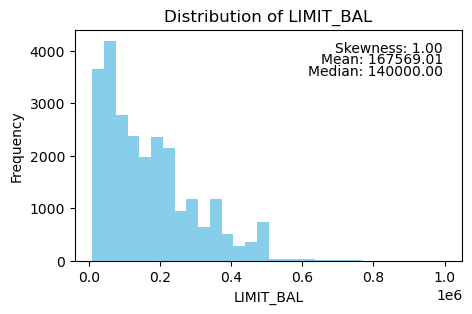

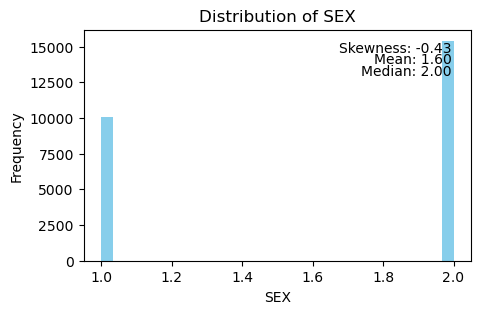

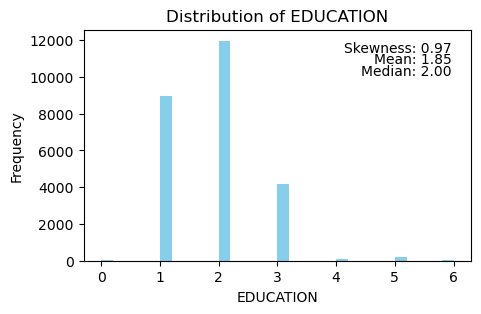

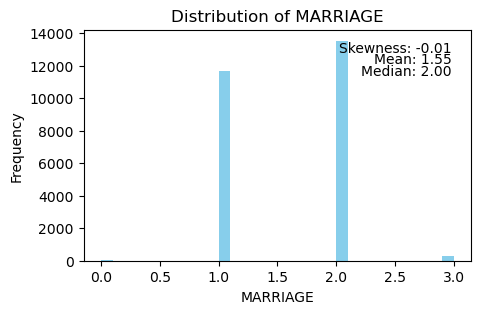

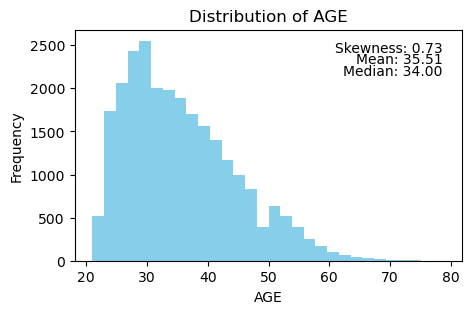

Skipping PAY_0 - This will be visualized in time-series plot.
Skipping PAY_2 - This will be visualized in time-series plot.
Skipping PAY_3 - This will be visualized in time-series plot.
Skipping PAY_4 - This will be visualized in time-series plot.
Skipping PAY_5 - This will be visualized in time-series plot.
Skipping PAY_6 - This will be visualized in time-series plot.
Skipping BILL_AMT1 - This will be visualized in time-series plot.
Skipping BILL_AMT2 - This will be visualized in time-series plot.
Skipping BILL_AMT3 - This will be visualized in time-series plot.
Skipping BILL_AMT4 - This will be visualized in time-series plot.
Skipping BILL_AMT5 - This will be visualized in time-series plot.
Skipping BILL_AMT6 - This will be visualized in time-series plot.
Skipping PAY_AMT1 - This will be visualized in time-series plot.
Skipping PAY_AMT2 - This will be visualized in time-series plot.
Skipping PAY_AMT3 - This will be visualized in time-series plot.
Skipping PAY_AMT4 - This will be visu

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

<Figure size 500x300 with 0 Axes>

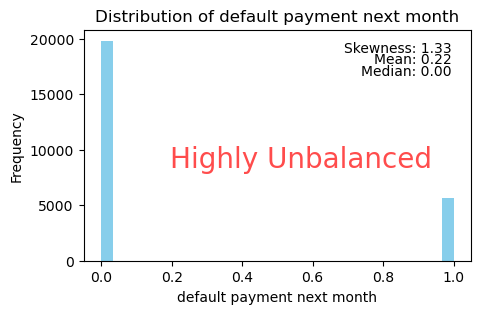

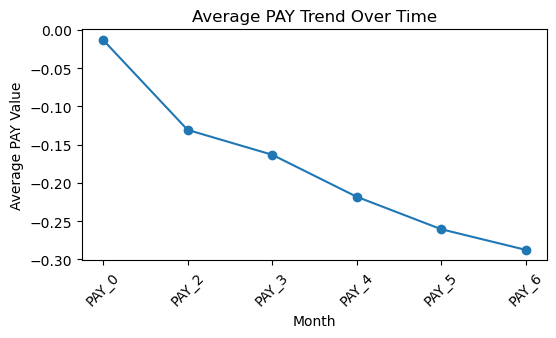

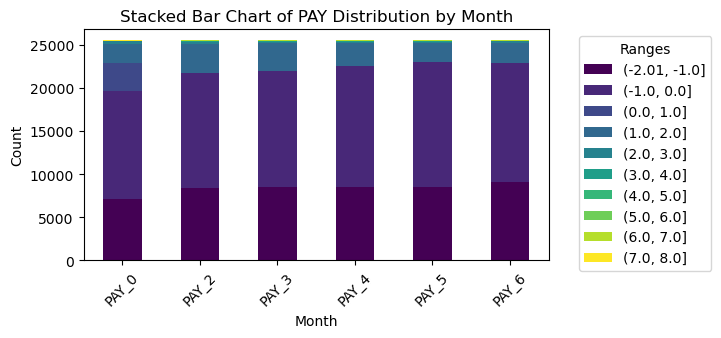

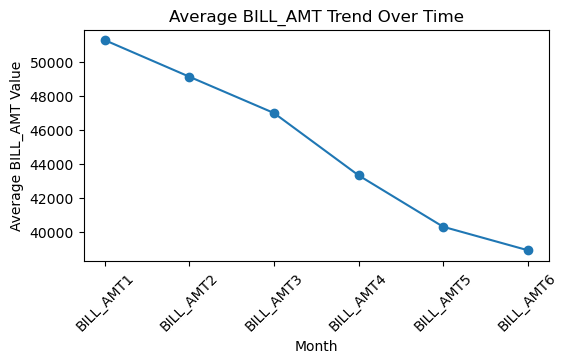

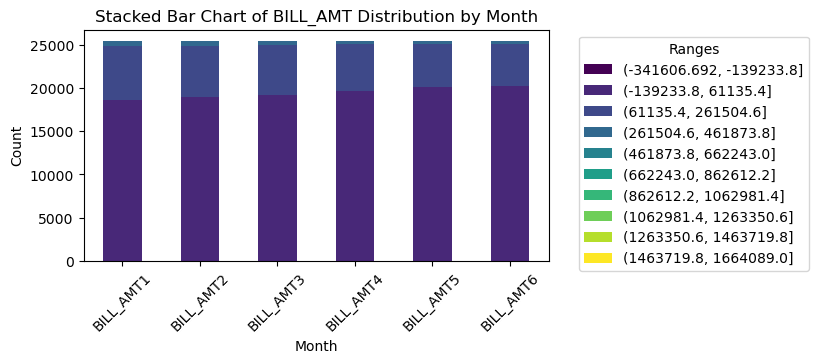

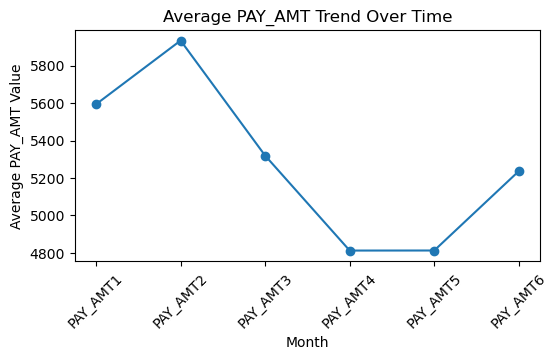

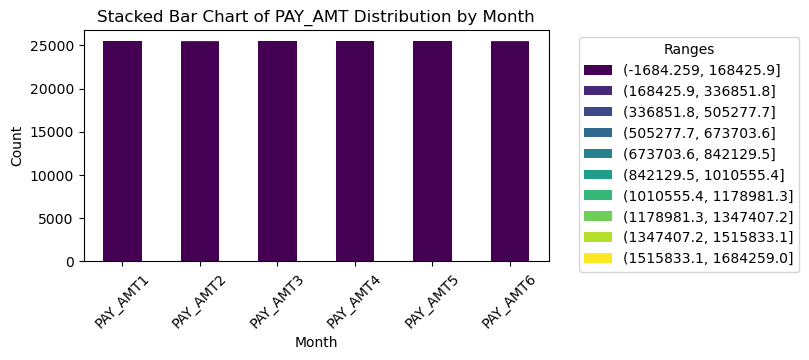

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew

# Define function to plot each feature's distribution and add annotations
def plot_feature_distributions(data):
    for column in data.columns:
        plt.figure(figsize=(5, 3))
        
        # Plot for numerical columns
        if pd.api.types.is_numeric_dtype(data[column]):
            # Skip time-series columns for dedicated plotting later
            if column.startswith(('PAY_', 'BILL_AMT', 'PAY_AMT')):
                print(f"Skipping {column} - This will be visualized in time-series plot.")
                continue
            else:
                plt.hist(data[column], bins=30, color='skyblue')
                plt.xlabel(column)
                plt.ylabel('Frequency')
                plt.title(f'Distribution of {column}')

                # Calculate skewness and highlight if it's unbalanced
                skewness = skew(data[column].dropna())
                mean = data[column].mean()
                median = data[column].median()

                # Add text to show skewness, mean, median
                plt.text(0.95, 0.95, f'Skewness: {skewness:.2f}', ha='right', va='top', transform=plt.gca().transAxes)
                plt.text(0.95, 0.90, f'Mean: {mean:.2f}', ha='right', va='top', transform=plt.gca().transAxes)
                plt.text(0.95, 0.85, f'Median: {median:.2f}', ha='right', va='top', transform=plt.gca().transAxes)

                # Highlight if distribution is highly skewed (e.g., skewness > 1 or < -1)
                if abs(skewness) > 1:
                    plt.text(0.9, 0.5, 'Highly Unbalanced', fontsize=20, color='red', alpha=0.7, ha='right', va='top', transform=plt.gca().transAxes)

                plt.show()
        
        # Plot for categorical columns
        elif pd.api.types.is_categorical_dtype(data[column]) or data[column].nunique() < 10:
            sns.countplot(data=data, x=column, palette='Set2')
            plt.xlabel(column)
            plt.ylabel('Count')
            plt.title(f'Distribution of {column}')

            # Check for imbalance in categorical columns
            value_counts = data[column].value_counts(normalize=True)
            if (value_counts > 0.7).any():
                plt.text(0.5, 0.5, 'Imbalanced Distribution', fontsize=20, color='red', alpha=0.7, ha='center', va='top')

            plt.show()
        
        else:
            print(f"Skipping {column} - Unknown data type.")

# Special function to handle grouped time-series payment history columns
def plot_time_series_groups(data):
    # Define time-series groups
    time_series_groups = {
        'PAY': ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'],
        'BILL_AMT': ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6'],
        'PAY_AMT': ['PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']
    }
    
    # Plot each group
    for group_name, columns in time_series_groups.items():
        # Plot average trend over time for each group
        plt.figure(figsize=(6, 3))
        avg_values = data[columns].mean()
        avg_values.plot(kind='line', marker='o', title=f'Average {group_name} Trend Over Time')
        plt.xlabel('Month')
        plt.ylabel(f'Average {group_name} Value')
        plt.xticks(range(len(columns)), columns, rotation=45)
        plt.show()
        
        # Stacked bar plot for each group to show distributions over months
        counts = pd.cut(data[columns].stack(), bins=10).unstack().apply(pd.Series.value_counts).fillna(0).T
        ax = counts.plot(kind='bar', stacked=True, figsize=(6, 3), cmap='viridis')
        plt.xlabel('Month')
        plt.ylabel('Count')
        plt.title(f'Stacked Bar Chart of {group_name} Distribution by Month')
        plt.xticks(range(len(columns)), columns, rotation=45)
        
        # Move the legend outside the plot
        plt.legend(title='Ranges', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.show()

# Load dataset (assuming it's loaded as `train_data`)
# train_data = pd.read_csv('train_data.csv')

# Call functions to plot distributions
plot_feature_distributions(train_data)
plot_time_series_groups(train_data)


According to the previous analysis the label column is the more unbalanced one, so i descided to represent it as a piechart giving the proportion of the unbalancig

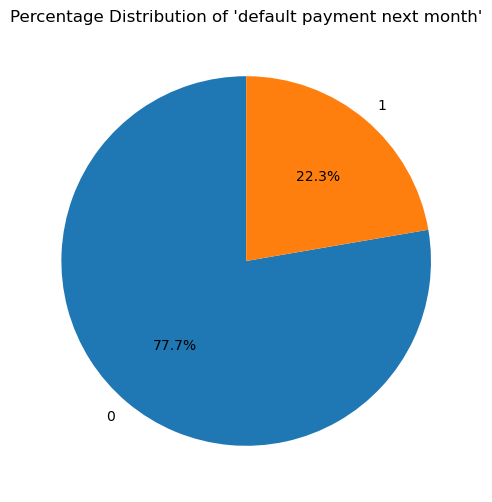

In [110]:
# Step 1: Calculate value counts with normalization
value_counts = train_data['default payment next month'].value_counts(normalize=True) * 100  # To get percentages

# Step 2: Plot the pie chart
plt.figure(figsize=(8, 6))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
plt.title("Percentage Distribution of 'default payment next month'")
plt.show()

In the code below i check if there is any particular correlation between non cateogorical features.
All features are numerical so i establish that all features with more than 11 disticnt values are non-categorical.

No strong correlations have been found and this lead me to think that there are no linear relationship between features and target column, for this reason the non linearity of a deep neural network should improve the classification task

Correlation Matrix:
           LIMIT_BAL       AGE  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  \
LIMIT_BAL   1.000000  0.144397   0.287568   0.279729   0.282812   0.294460   
AGE         0.144397  1.000000   0.060210   0.056886   0.056034   0.052833   
BILL_AMT1   0.287568  0.060210   1.000000   0.950988   0.889703   0.858889   
BILL_AMT2   0.279729  0.056886   0.950988   1.000000   0.926561   0.892435   
BILL_AMT3   0.282812  0.056034   0.889703   0.926561   1.000000   0.920891   
BILL_AMT4   0.294460  0.052833   0.858889   0.892435   0.920891   1.000000   
BILL_AMT5   0.296433  0.051360   0.828522   0.860044   0.881611   0.940703   
BILL_AMT6   0.291890  0.048525   0.800649   0.830561   0.851122   0.901089   
PAY_AMT1    0.196191  0.023687   0.143863   0.279022   0.238959   0.232864   
PAY_AMT2    0.172251  0.021051   0.096258   0.099341   0.316671   0.198857   
PAY_AMT3    0.213681  0.029600   0.162959   0.155715   0.131591   0.301681   
PAY_AMT4    0.206756  0.024933   0.154956   

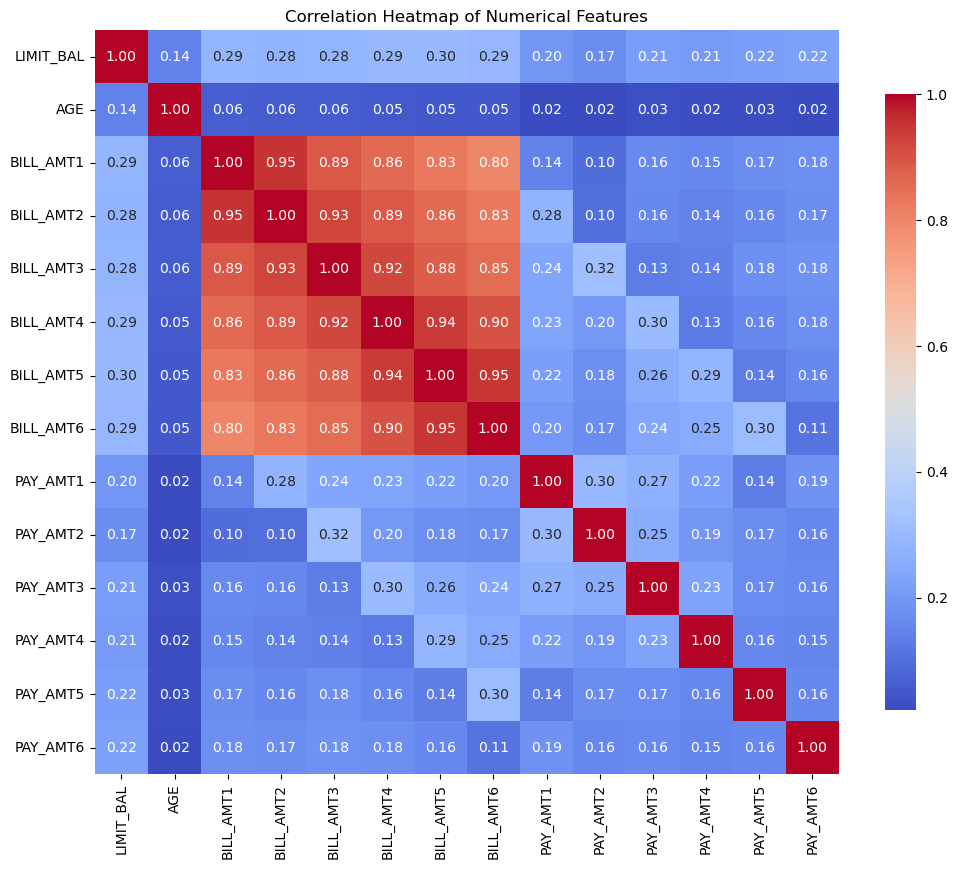


Strongly Correlated Features (|correlation| > 0.7):
BILL_AMT2 and BILL_AMT1: 0.95
BILL_AMT3 and BILL_AMT1: 0.89
BILL_AMT3 and BILL_AMT2: 0.93
BILL_AMT4 and BILL_AMT1: 0.86
BILL_AMT4 and BILL_AMT2: 0.89
BILL_AMT4 and BILL_AMT3: 0.92
BILL_AMT5 and BILL_AMT1: 0.83
BILL_AMT5 and BILL_AMT2: 0.86
BILL_AMT5 and BILL_AMT3: 0.88
BILL_AMT5 and BILL_AMT4: 0.94
BILL_AMT6 and BILL_AMT1: 0.80
BILL_AMT6 and BILL_AMT2: 0.83
BILL_AMT6 and BILL_AMT3: 0.85
BILL_AMT6 and BILL_AMT4: 0.90
BILL_AMT6 and BILL_AMT5: 0.95


In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Function to check correlations between numerical features
def check_correlations(data):
    # Exclude categorical features and features with less than 10 distinct values
    numerical_data = data.select_dtypes(include=['number'])  # Select only numerical columns
    numerical_data = numerical_data.loc[:, numerical_data.nunique() >= 12]  # Keep columns with >= 10 distinct values

    # Compute the correlation matrix
    correlation_matrix = numerical_data.corr()

    # Display the correlation matrix
    print("Correlation Matrix:")
    print(correlation_matrix)

    # Visualize the correlation matrix with a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title('Correlation Heatmap of Numerical Features')
    plt.show()

    # Identify and print pairs of strongly correlated features
    strong_correlations = []
    threshold = 0.7
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > threshold:
                strong_correlations.append((correlation_matrix.columns[i], correlation_matrix.columns[j], correlation_matrix.iloc[i, j]))

    print("\nStrongly Correlated Features (|correlation| > 0.7):")
    for feature1, feature2, corr in strong_correlations:
        print(f"{feature1} and {feature2}: {corr:.2f}")

# Load dataset (assuming it's loaded as `train_data`)
# train_data = pd.read_csv('train_data.csv')

# Call the function to check for correlations
check_correlations(train_data)


Similarly as above, i check if there is any particular correlation between cateogorical features.
All features are numerical so i establish that all features with less than 12 disticnt values are considered categorical.

No strong correlations have been found.

Cramér's V Correlation Matrix for Numerical Features with < 10 Distinct Values:
                                 SEX EDUCATION  MARRIAGE     PAY_0     PAY_2  \
SEX                              NaN  0.030611  0.028862  0.066616  0.075733   
EDUCATION                   0.030611       NaN  0.114658  0.083454  0.089572   
MARRIAGE                    0.028862  0.114658       NaN  0.036068  0.032173   
PAY_0                       0.066616  0.083454  0.036068       NaN  0.670612   
PAY_2                       0.075733  0.089572  0.032173  0.670612       NaN   
PAY_3                       0.071971  0.085892  0.031551  0.521619  0.626802   
PAY_4                       0.066675   0.08034  0.035394   0.41612  0.481974   
PAY_5                       0.059482  0.073677  0.033394  0.357831  0.388543   
PAY_6                       0.049462  0.070425  0.030711  0.315148  0.335568   
default payment next month  0.042292  0.070742  0.030912  0.420467  0.342041   

                               PAY_3   

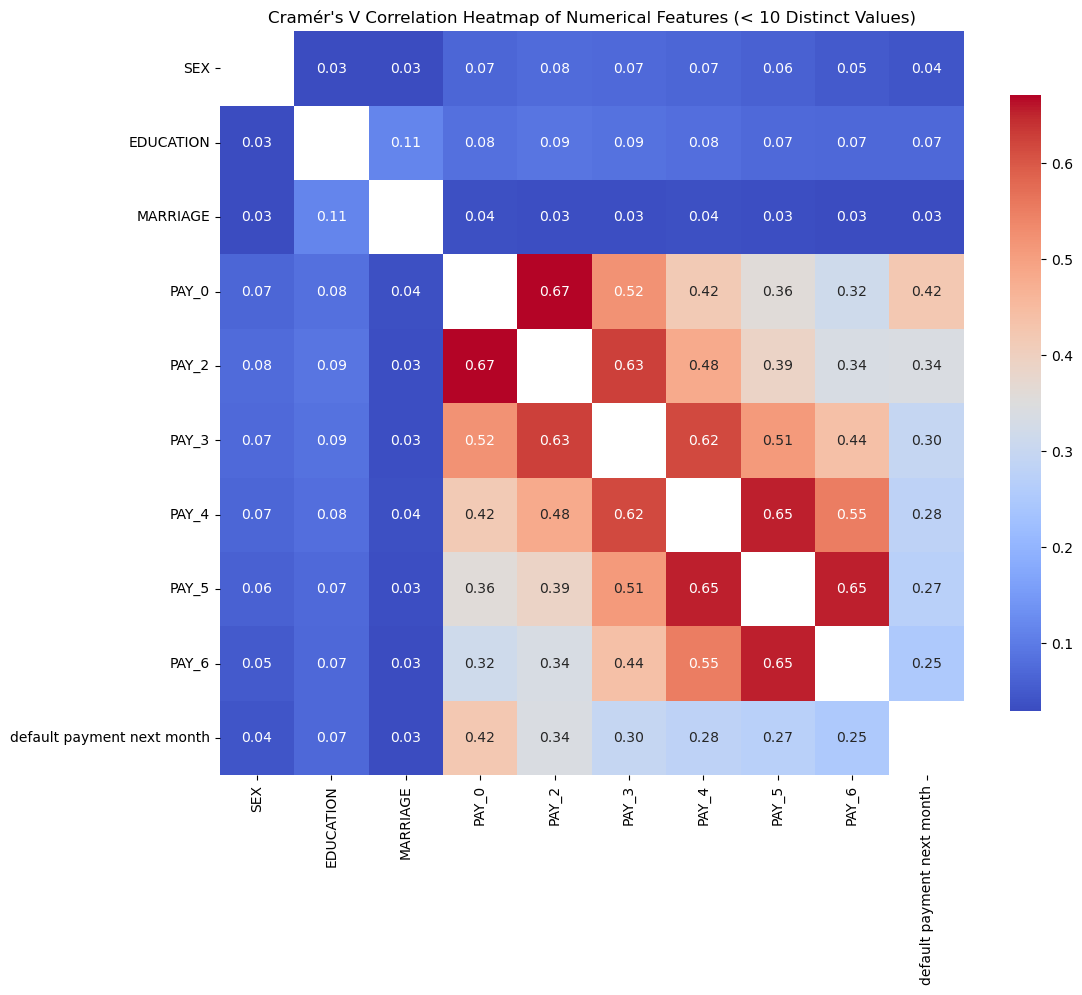

In [54]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

# Function to compute Cramér's V
def cramers_v(x, y):
    contingency_table = pd.crosstab(x, y)
    chi2 = chi2_contingency(contingency_table)[0]
    n = contingency_table.sum().sum()
    phi2 = chi2 / n
    r, k = contingency_table.shape
    phi2cor = max(0, phi2 - (k - 1) * (r - 1) / (n - 1))
    rcorr = r - 1
    kcorr = k - 1
    return np.sqrt(phi2cor / min((kcorr, rcorr)))

# Function to compute correlation matrix for categorical-like numerical features
def check_numerical_correlations(data):
    # Select numerical columns with less than 10 distinct values
    numerical_columns = data.select_dtypes(include=['number']).columns.tolist()
    low_distinct_numerical = [col for col in numerical_columns if data[col].nunique() < 12]
    
    n = len(low_distinct_numerical)
    
    # Create a DataFrame to hold Cramér's V values
    corr_matrix = pd.DataFrame(index=low_distinct_numerical, columns=low_distinct_numerical)

    # Compute Cramér's V for each pair of numerical features with low distinct values
    for i in range(n):
        for j in range(i + 1, n):
            corr_value = cramers_v(data[low_distinct_numerical[i]], data[low_distinct_numerical[j]])
            corr_matrix.iloc[i, j] = corr_value
            corr_matrix.iloc[j, i] = corr_value  # Symmetric matrix

    # Display the correlation matrix
    print("Cramér's V Correlation Matrix for Numerical Features with < 10 Distinct Values:")
    print(corr_matrix)

    # Visualize the correlation matrix with a heatmap
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix.astype(float), annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
    plt.title("Cramér's V Correlation Heatmap of Numerical Features (< 10 Distinct Values)")
    plt.show()


# Call the function to check for numerical correlations
check_numerical_correlations(train_data)


Looking for strong presence of outliers using Interquartile Range (Outliers are identified as values lying outside 1.5 times the IQR from Q1 or Q3).

If the number of outliers identified by IQR is greater than 10% of the total instances an alert is displayed on the right of the chart.

Outlier Summary:
             Feature  Outliers_ZScore  Outliers_IQR
LIMIT_BAL  LIMIT_BAL             2474           144
AGE              AGE             2474           236
BILL_AMT1  BILL_AMT1             2474          2053
BILL_AMT2  BILL_AMT2             2474          2052
BILL_AMT3  BILL_AMT3             2474          2108
BILL_AMT4  BILL_AMT4             2474          2245
BILL_AMT5  BILL_AMT5             2474          2310
BILL_AMT6  BILL_AMT6             2474          2296
PAY_AMT1    PAY_AMT1             2474          2348
PAY_AMT2    PAY_AMT2             2474          2319
PAY_AMT3    PAY_AMT3             2474          2218
PAY_AMT4    PAY_AMT4             2474          2573
PAY_AMT5    PAY_AMT5             2474          2525
PAY_AMT6    PAY_AMT6             2474          2504


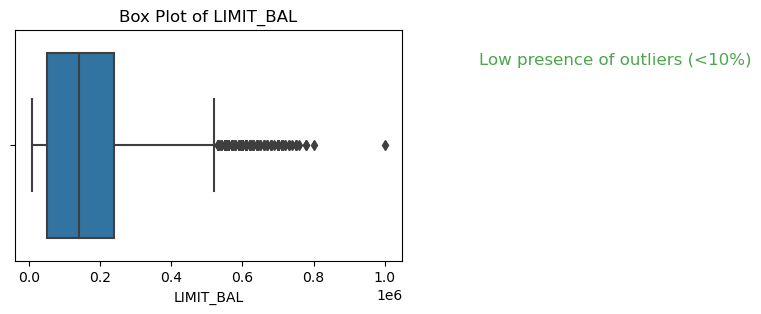

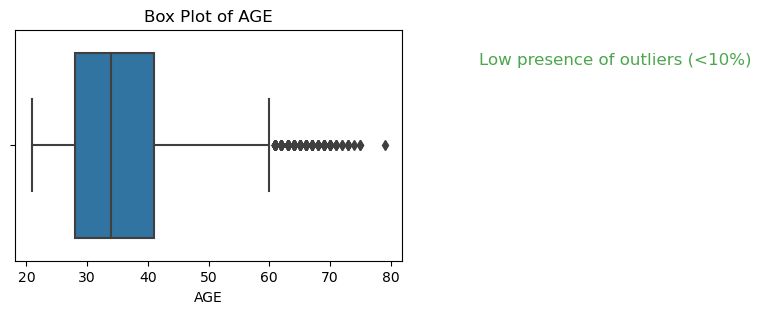

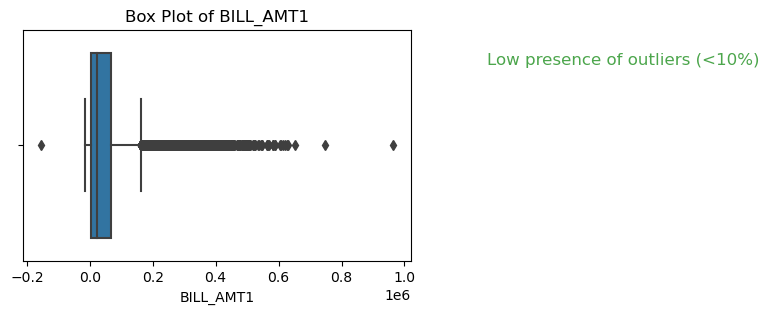

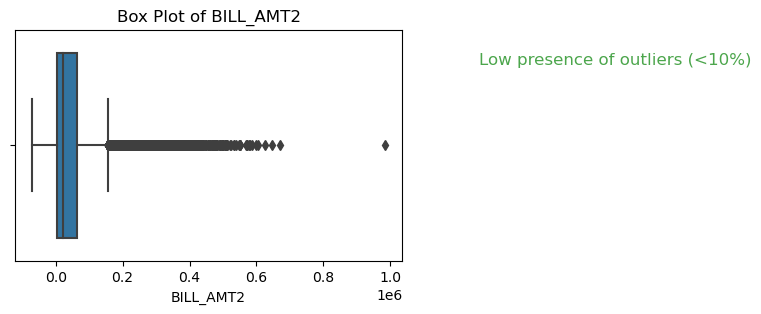

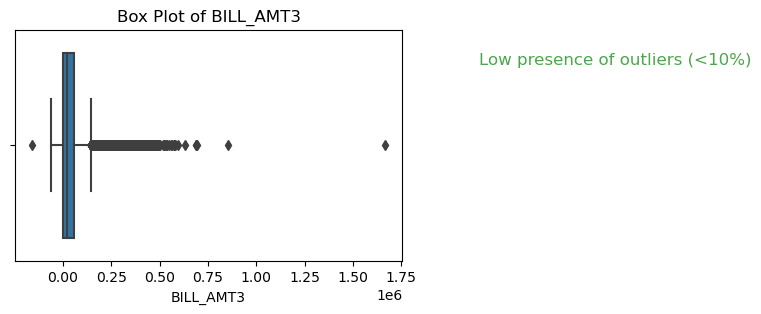

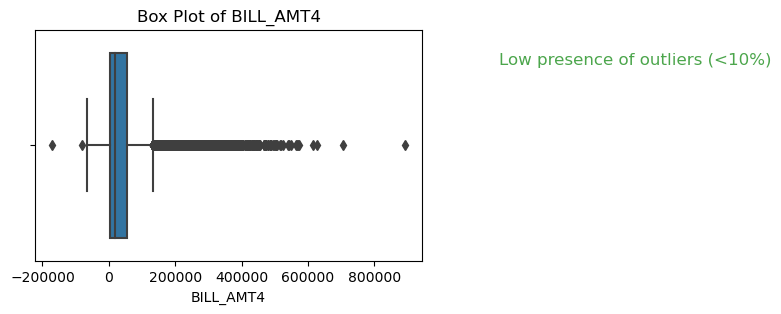

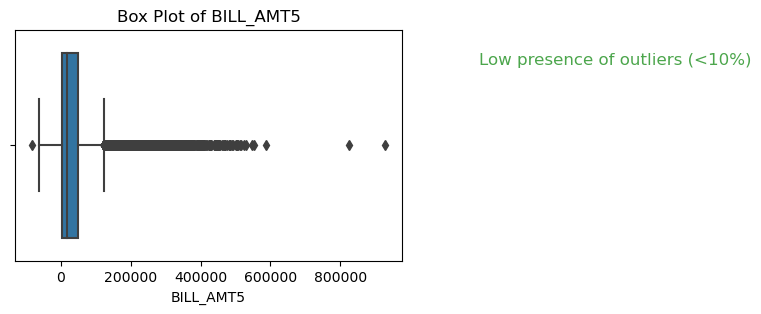

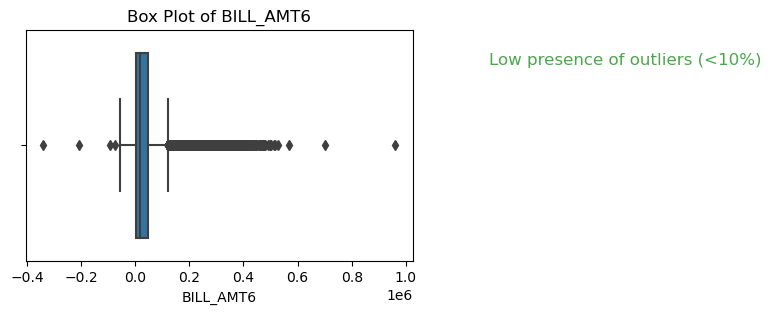

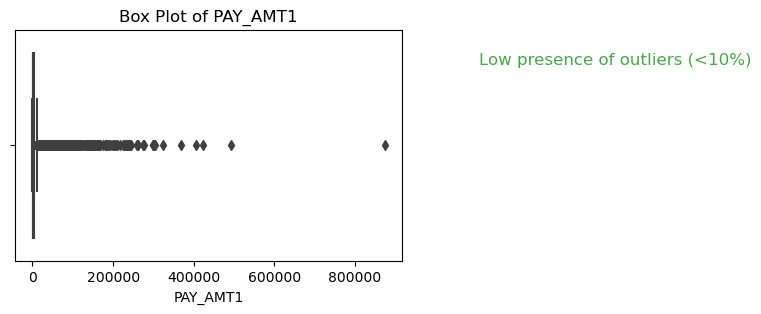

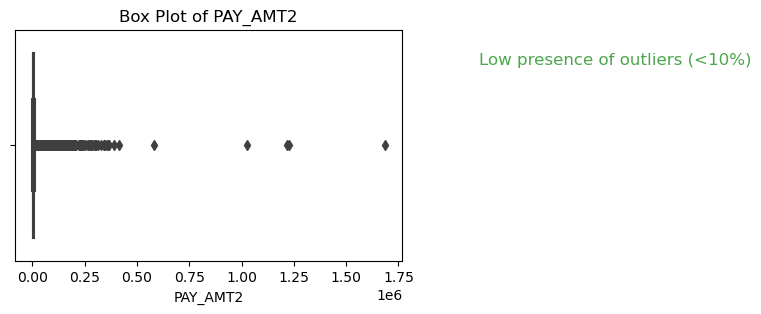

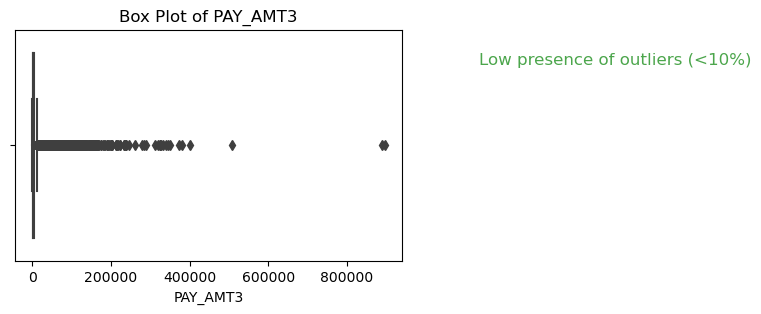

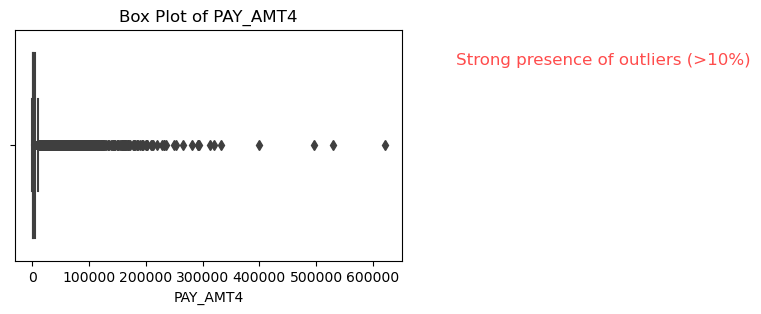

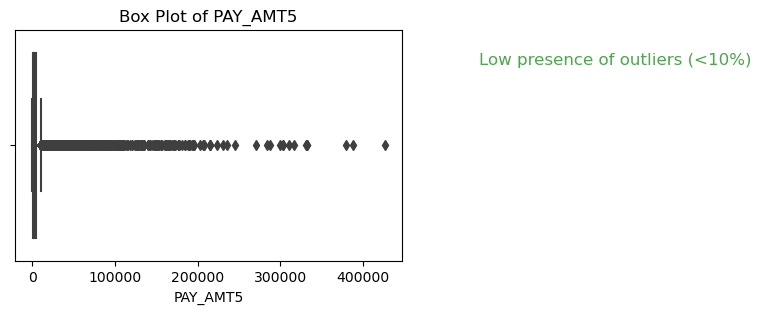

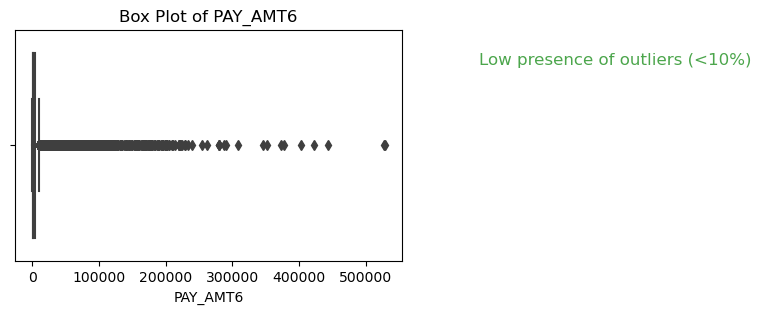

In [70]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Function to identify outliers using Z-score
def identify_outliers_zscore(data, threshold=3):
    z_scores = np.abs(stats.zscore(data))
    return (z_scores > threshold).any(axis=1)

# Function to identify outliers using IQR
def identify_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return (data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))

# Function to visualize outliers with box plots and annotations
def visualize_outliers(data, columns, threshold_percentage):
    total_count = len(data)
    threshold_value = int(total_count * threshold_percentage)
    
    for column in columns:
        plt.figure(figsize=(5, 3))
        sns.boxplot(x=data[column])
        plt.title(f'Box Plot of {column}')
        plt.xlabel(column)

        # Count outliers
        outlier_count = data[column][identify_outliers_iqr(data[column])].count()

        # Determine the presence of outliers
        if outlier_count > threshold_value:
            presence_text = 'Strong presence of outliers (>10%)'
            color = 'red'
        else:
            presence_text = 'Low presence of outliers (<10%)'
            color = 'green'

        # Annotate based on presence
        plt.text(1.9, 0.9, presence_text, fontsize=12, color=color, alpha=0.7, ha='right', va='top', transform=plt.gca().transAxes)
        
        plt.show()

# Function to identify and visualize outliers in key numeric features
def identify_and_visualize_outliers(data, key_numeric_features, threshold_percentage=0.10):
    # Identify outliers
    outliers_zscore = identify_outliers_zscore(data[key_numeric_features])
    outliers_iqr = identify_outliers_iqr(data[key_numeric_features])

    # Create a DataFrame for outlier results
    outlier_summary = pd.DataFrame({
        'Feature': key_numeric_features,
        'Outliers_ZScore': outliers_zscore.sum(),
        'Outliers_IQR': outliers_iqr.sum()
    })

    # Display outlier summary
    print("Outlier Summary:")
    print(outlier_summary)

    # Visualize outliers with annotations
    visualize_outliers(data, key_numeric_features, threshold_percentage)

# Load dataset (assuming it's loaded as `train_data`)
# train_data = pd.read_csv('train_data.csv')

# Specify key numeric features
numerical_columns = train_data.select_dtypes(include=['number']).columns.tolist()
key_numeric_features = [col for col in numerical_columns if train_data[col].nunique() > 12]

# Call the function to identify and visualize outliers
identify_and_visualize_outliers(train_data, key_numeric_features)


## Preparing the data

describe the choice made during the preprocessing operations, also taking into account the previous considerations during the data inspection.

In [72]:
# ! id column has been dropped previously

# Separate features and target variable
# Assuming the target variable is named 'default_payment'
target_column = 'default payment next month'  # Label
X = train_data.drop(columns=[target_column])  # Features
y = train_data[target_column]  # Target variable

# Train-validation split
# Perform an 80/20 split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Standardize numerical features
scaler = StandardScaler()

# Fit the scaler on the training data and transform both the training and validation sets
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Convert back to DataFrame for easier handling later
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns)

# Display shapes of the datasets
print("Training set shape:", X_train_scaled.shape, y_train.shape)
print("Validation set shape:", X_val_scaled.shape, y_val.shape)

Training set shape: (20400, 23) (20400,)
Validation set shape: (5100, 23) (5100,)


## Building the network

any description/comment about the procedure you followed in the choice of the network structure and hyperparameters goes here, together with consideration about the training/optimization procedure (e.g. optimizer choice, final activations, loss functions, training metrics)

As First analysis on model's performance related to hyperparameters' values i started by fine-tunining on hyperparamter at a time leaving the others invariated.

This option has the following advantages:
    - Saving time and computation resources compared to trying all possible distinct combinations of hyperparameters
    - Isolating the effect of each hyperparameter, which can be helpful for understanding its impact on model performance.
    - Using the best hyperparameter's value of the previouses trials as default value as strategy to improve model's
        performances (according to accuracy score against validation data)
    
Obviously this approach doesn't take into account potential interactions between hyperparameters

Fine Tuning on num_layers
Values to try:  [1, 2, 3, 4]
Total number of trials: 4
Best Hyperparameters: {'num_layers': 1, 'l1': 0.0, 'l2': 0.0, 'units': 64, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Best Validation Accuracy: 0.8182352781295776
Worst Hyperparameters: {'num_layers': 2, 'l1': 0.0, 'l2': 0.0, 'units': 64, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Worst Validation Accuracy: 0.8029412031173706
Best value for num_layers: 1
[1, 2, 3, 4]
[0.8182352781295776, 0.8176470398902893, 0.8147059082984924, 0.8164705634117126]
[0.817794144153595, 0.8202941417694092, 0.8193627595901489, 0.817794144153595]


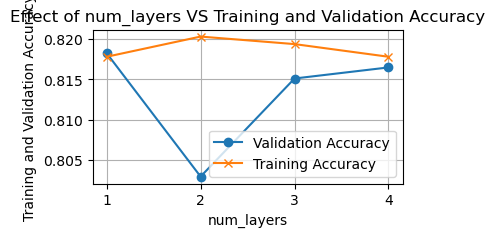

Fine Tuning on l1
Values to try:  [0.0, 0.001, 0.01, 0.1]
Total number of trials: 4
Best Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.0, 'units': 64, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Best Validation Accuracy: 0.8184313774108887
Worst Hyperparameters: {'num_layers': 1, 'l1': 0.1, 'l2': 0.0, 'units': 64, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Worst Validation Accuracy: 0.7858823537826538
Best value for l1: 0.01
[0.0, 0.001, 0.01, 0.1]
[0.8182352781295776, 0.8176470398902893, 0.8147059082984924, 0.8164705634117126]
[0.8175489902496338, 0.8169117569923401, 0.8133333325386047, 0.7986274361610413]


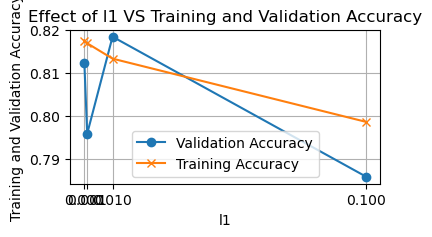

Fine Tuning on l2
Values to try:  [0.0, 0.001, 0.01, 0.1]
Total number of trials: 4
Best Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 64, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Best Validation Accuracy: 0.8164705634117126
Worst Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.1, 'units': 64, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Worst Validation Accuracy: 0.8101961016654968
Best value for l2: 0.001
[0.0, 0.001, 0.01, 0.1]
[0.8182352781295776, 0.8176470398902893, 0.8147059082984924, 0.8164705634117126]
[0.8134803771972656, 0.8140196204185486, 0.8132843375205994, 0.8054901957511902]


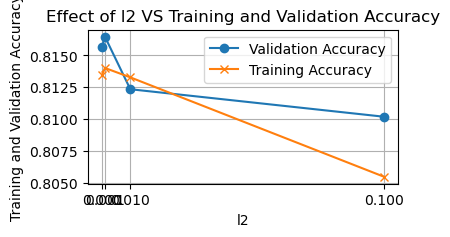

Fine Tuning on units
Values to try:  [32, 64, 96, 128]
Total number of trials: 4
Best Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Best Validation Accuracy: 0.8150980472564697
Worst Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 64, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Worst Validation Accuracy: 0.8050980567932129
Best value for units: 32
[32, 64, 96, 128]
[0.8182352781295776, 0.8176470398902893, 0.8147059082984924, 0.8164705634117126]
[0.8128431439399719, 0.811960756778717, 0.8154411911964417, 0.814460813999176]


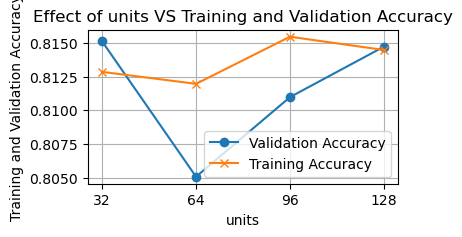

Fine Tuning on dropout
Values to try:  [0.0, 0.1, 0.5]
Total number of trials: 3
Best Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Best Validation Accuracy: 0.8164705634117126
Worst Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.5, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Worst Validation Accuracy: 0.8023529648780823
Best value for dropout: 0.0
[0.0, 0.1, 0.5]
[0.8182352781295776, 0.8176470398902893, 0.8147059082984924, 0.8164705634117126]
[0.8151470422744751, 0.8103921413421631, 0.7938725352287292]


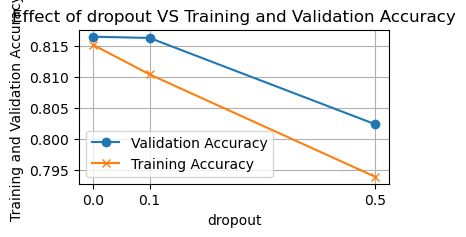

Fine Tuning on activation
Values to try:  ['relu', 'tanh']
Total number of trials: 2
Best Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Best Validation Accuracy: 0.8166666626930237
Worst Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'relu', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Worst Validation Accuracy: 0.815490186214447
Best value for activation: tanh
['relu', 'tanh']
[0.8182352781295776, 0.8176470398902893, 0.8147059082984924, 0.8164705634117126]
[0.813039243221283, 0.8160784244537354]


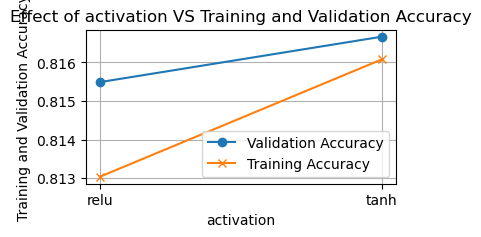

Fine Tuning on optimizer
Values to try:  ['adam', 'sgd']
Total number of trials: 2
Best Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.01, 'batch_size': 32}
Best Validation Accuracy: 0.8176470398902893
Worst Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'tanh', 'optimizer': 'adam', 'learning_rate': 0.01, 'batch_size': 32}
Worst Validation Accuracy: 0.8162745237350464
Best value for optimizer: sgd
['adam', 'sgd']
[0.8182352781295776, 0.8176470398902893, 0.8147059082984924, 0.8164705634117126]
[0.8156372308731079, 0.8164215683937073]


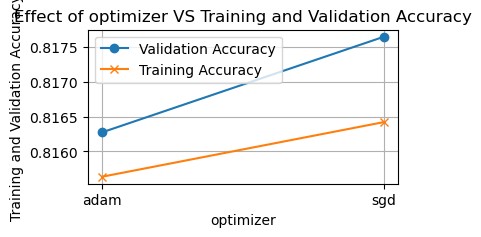

Fine Tuning on learning_rate
Values to try:  [0.01, 0.005, 0.001]
Total number of trials: 3
Best Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.01, 'batch_size': 32}
Best Validation Accuracy: 0.8176470398902893
Worst Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.001, 'batch_size': 32}
Worst Validation Accuracy: 0.8033333420753479
Best value for learning_rate: 0.01
[0.01, 0.005, 0.001]
[0.8182352781295776, 0.8176470398902893, 0.8147059082984924, 0.8164705634117126]
[0.8167647123336792, 0.8098529577255249, 0.8025980591773987]


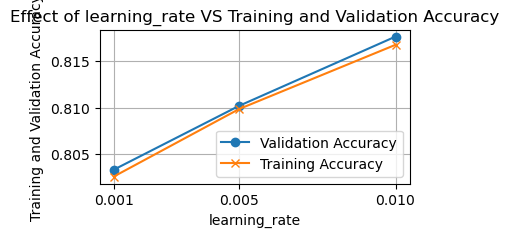

Fine Tuning on batch_size
Values to try:  [32, 64, 96, 128]
Total number of trials: 4
Best Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.01, 'batch_size': 32}
Best Validation Accuracy: 0.817254900932312
Worst Hyperparameters: {'num_layers': 1, 'l1': 0.01, 'l2': 0.001, 'units': 32, 'dropout': 0.0, 'activation': 'tanh', 'optimizer': 'sgd', 'learning_rate': 0.01, 'batch_size': 128}
Worst Validation Accuracy: 0.7960784435272217
Best value for batch_size: 32
[32, 64, 96, 128]
[0.8182352781295776, 0.8176470398902893, 0.8147059082984924, 0.8164705634117126]
[0.8165686130523682, 0.8039705753326416, 0.802647054195404, 0.7892646789550781]


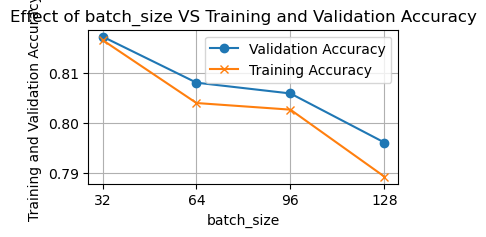

In [125]:
# Define a function to build and evaluate a model based on a specific combination of hyperparams
def evaluate_model(hyperparams):
    model = keras.Sequential()
    model.add(layers.Input(shape=(X_train_scaled.shape[1],)))

    num_layers = hyperparams['num_layers']
    
    # setting there hyperparams related to layer design
    for i in range(num_layers):
        l1_penalty = hyperparams['l1']
        l2_penalty = hyperparams['l2']

        model.add(layers.Dense(
            units=hyperparams['units'],
            activation=hyperparams['activation'],
            kernel_regularizer=regularizers.l1_l2(l1=l1_penalty, l2=l2_penalty)
        ))
        model.add(layers.Dropout(rate=hyperparams['dropout']))
    
    # the output is binary and must be represente in one dimension
    ### a layer of 1 neuron wiht a signmoid activation function fits this goal
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Set optimizer with learning rate
    if hyperparams['optimizer'] == 'adam':
        optimizer = keras.optimizers.Adam(learning_rate=hyperparams['learning_rate'])
    elif hyperparams['optimizer'] == 'sgd':
        optimizer = keras.optimizers.SGD(learning_rate=hyperparams['learning_rate'])

    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Train and validate* the model
    ### * in this case the fit method use the default validations strategy: hold-out validation
    ### This strategy involves splitting the data into a fixed training set and a validation set
    ### the hold-out set remains the same across all epochs (differently from cross-validation)
    history = model.fit(X_train_scaled, y_train, epochs=20, validation_data=(X_val_scaled, y_val), batch_size=hyperparams['batch_size'], verbose=0)
    
    # Get training and validation accuracy from the history
    training_accuracy = history.history['accuracy'][-1]
    
    loss, val_accuracy = model.evaluate(X_val_scaled, y_val, verbose=0)
    
    return val_accuracy, training_accuracy


# define a function to try all combinations of hyperaparameters passed as input
def start_trial(hyperparams_dict):
    # Calculate the total number of trials based on the hyperparameter values
    trials_number = 1
    for values in hyperparams_dict.values():
        trials_number *= len(values)

    print(f'Total number of trials: {trials_number}')

    # Generate all combinations of hyperparameters
    results = []

    for num_layers in hyperparams_dict['num_layers']:
        for l1 in hyperparams_dict['l1']:
            for l2 in hyperparams_dict['l2']:
                for units in hyperparams_dict['units']:
                    for dropout in hyperparams_dict['dropout']:
                        for activation in hyperparams_dict['activation']:
                            for optimizer in hyperparams_dict['optimizer']:
                                for learning_rate in hyperparams_dict['learning_rate']:
                                    for batch_size in hyperparams_dict['batch_size']:
                                        hyperparams = {
                                            'num_layers': num_layers,
                                            'l1': l1,
                                            'l2': l2,
                                            'units': units,
                                            'dropout': dropout,
                                            'activation': activation,
                                            'optimizer': optimizer,
                                            'learning_rate': learning_rate,
                                            'batch_size': batch_size
                                        }
                                        
                                        val_accuracy, training_accuracy = evaluate_model(hyperparams)
                                        results.append((hyperparams, val_accuracy, training_accuracy))

    # Find the best combination
    best_hyperparams, best_accuracy, best_train_accuracy = max(results, key=lambda x: x[1])
    print(f'Best Hyperparameters: {best_hyperparams}')
    print(f'Best Validation Accuracy: {best_accuracy}')
    
    worst_hyperparams, worst_accuracy, worst_train_accuracy = min(results, key=lambda x: x[1])
    print(f'Worst Hyperparameters: {worst_hyperparams}')
    print(f'Worst Validation Accuracy: {worst_accuracy}')
    
    
    return best_hyperparams, results



# Define hyperparameter with default values values in a dictionary
hyperparams_dict = {
    'num_layers': [3],            # Range for number of layers
    'l1': [0.0],             # L1 penalty range
    'l2': [0.0],             # L2 penalty range
    'units': [64],              # Units in dense layers
    'dropout': [0.0],         # Dropout rate range
    'activation': ['relu'], #'tanh'],     # Activation functions
    'optimizer': ['adam'], #, 'sgd'],       # Optimizers
    'learning_rate': [0.01],     # Learning rates
    'batch_size': [32]          # Batch sizes
}

# Define the whole list of values i want to try for each hyperparameter
hyperparams_dict_values_to_try = {
    'num_layers': [1, 2, 3, 4],            # Range for number of layers
    'l1': [0.0, 0.001, 0.01, 0.1],             # L1 penalty range
    'l2': [0.0, 0.001, 0.01, 0.1],             # L2 penalty range
    'units': [32, 64, 96, 128],              # Units in dense layers
    'dropout': [0.0, 0.1, 0.5],         # Dropout rate range
    'activation': ['relu', 'tanh'], #'tanh'],     # Activation functions
    'optimizer': ['adam', 'sgd'], #, 'sgd'],       # Optimizers
    'learning_rate': [0.01, 0.005, 0.001],     # Learning rates
    'batch_size': [32, 64, 96, 128]          # Batch sizes
}


# looping over each hyperparameter we want to track leaving the others unchanged
for hp_to_track in hyperparams_dict:
    print(f"Fine Tuning on {hp_to_track}")
    
    hp_list = []
    val_accuracy_list = []
    train_accuracy_list = []
    
    # updating hyperparams default dict with the list of values to try for the specific hp_to_track
    hyperparams_dict[hp_to_track] = hyperparams_dict_values_to_try[hp_to_track]
    print("Values to try: ",  hyperparams_dict[hp_to_track])
    
    best_hyperparams, results = start_trial(hyperparams_dict)
    
    best_hp_tracked = best_hyperparams[hp_to_track]
    print(f'Best value for {hp_to_track}: {best_hp_tracked}')
    
    # updating hyperparams_dict with the best hp tracked value in the last tuning
    hyperparams_dict[hp_to_track] = [best_hp_tracked]
    
    # extracting trial's results data
    for result in results:
        hp_list.append(result[0][hp_to_track])
        val_accuracy_list.append(result[1])
        train_accuracy_list.append(result[2])
    
    #print(results)
    
    print(hp_list)
    print(accuracy_list)
    print(train_accuracy_list)
    
    results_df = pd.DataFrame(
                    {
                        hp_to_track: hp_list,
                        'val_accuracy': val_accuracy_list,
                        'train_accuracy': train_accuracy_list
                    }
                )

    # Plot the results
    plt.figure(figsize=(4, 2))
    # Plotting validation accuracy
    plt.plot(results_df[hp_to_track], results_df['val_accuracy'], marker='o', label='Validation Accuracy')

    # Plotting training accuracy
    plt.plot(results_df[hp_to_track], results_df['train_accuracy'], marker='x', label='Training Accuracy')
    
    plt.title(f'Effect of {hp_to_track} VS Training and Validation Accuracy')
    plt.xlabel(hp_to_track)
    plt.ylabel('Training and Validation Accuracy')
    plt.xticks(results_df[hp_to_track])  # Set x-ticks to the units explored
    plt.legend()
    plt.grid(True)
    plt.show()

## Analyze and comment the training results

here goes any comment/visualization of the training history and any initial consideration on the training results  

What follows is a list of reasons and trial observations i have cosidered in choosing the hyperparameters:

num_layers: Adding more layers can allow the model to learn more complex patterns but may also lead to overfitting if not controlled carefully. As shown in the graph below accuracy decreases as the number of layers rises but moving from 3 to 4 layers it increases.

l1 and l2 regularization: These penalties prevent overfitting by adding constraints to weights. They can improve accuracy on validation data if the model tends to overfit.
In the trial performed, Validation accuracy is always greater than training accuracy when l2 regulation penalty values reach the max value. 

units: The number of units in a dense layer influences the model's capacity to capture patterns. Too few units may underfit, while too many can overfit. 
By the way, according to experiment results, we can do strong considerations on this hyperparameter.

dropout: Dropout randomly drops neurons during training to prevent overfitting. A small dropout can help regularize the model without reducing its capacity significantly.
According to trial data, as expected, validation accuracy is greater than training accuracy when dropout factor is greater than zero.

activation: The choice of activation function can impact the ability to capture complex patterns. For instance, ReLU is effective for many deep learning tasks, while Tanh may be more useful in certain neural architectures.

optimizer: Different optimizers converge at different speeds and stabilities. Adam is popular for its adaptive learning rate, while SGD can sometimes generalize better with longer training.

learning_rate: A higher learning rate may make the model converge faster but risks overshooting, whereas a lower rate makes convergence slow but more stable.

batch_size: A larger batch size offers a more stable gradient estimation, while smaller batch sizes provide noisier gradients that can improve generalization.

##### An importat point to keep in mind while considering the data expressed in the chart is that as the trials go on the hyperparams values that reward the validation accuracy are seleted so it's understandable that in the last charts validation accuracy score is often greater than training accuracy. 

## Validate the model and comment the results

please describe the evaluation procedure on a validation set, commenting the generalization capability of your model (e.g. under/overfitting). You may also describe the performance metrics that you choose: what is the most suitable performance measure (or set of performance measures) in this case/dataset, according to you? Why?

In evaluating my model on the validation set, I focused on understanding its generalization capabilities, particularly looking for signs of underfitting or overfitting. I employed a One-at-a-Time Tuning Strategy to explore the impact of individual hyperparameters on model accuracy. This approach revealed that while some hyperparameters exhibited a linear relationship with accuracy (as the number of units and regularization techniques L1 and L2), others did not show a significant impact. This suggests that there are likely hidden interactions between hyperparameters that influence model performance in more complex ways.

Overall, I observed that my model achieved better accuracy than a naive classification method based solely on label frequency distribution. However, I noted that the accuracy did not vary significantly across different hyperparameter combinations (from 0.80 up to 0.82). 

A more complete analysis could consider the limitations of using accuracy as the sole performance metric, especially given the class imbalance in my dataset (0 making up 78% and 1 only 22%).

For example, incorporate additional performance metrics such as F1-score, precision, and recall could improve the analysis quality. The F1-score is particularly relevant as it considers both precision and recall, providing a more balanced view of the model's performance. Precision will help me understand how many of the predicted positives were actually positive, while recall will show how well the model captures all actual positives. These metrics should give me a clearer understanding of my model's effectiveness, especially regarding the minority class, and help guide further tuning and improvements.

## Make predictions (on the provided test set)

Based on the results obtained and analyzed during the training and the validation phases, what are your (rather _personal_) expectations with respect to the performances of your model on the blind external test set? Briefly motivate your answer.

Considering the accuracy range obtained againts validation dataset in the trials (0.80 - 0.82), as i said, it's better than a naive classifier based on target column frequency but not so high to let me think of a case of over-fitting (no big differences found between training and validation accuracy). So i can assume that the distinct versions of neural networks evaluated have sufficiently generalized the problem with a good accuracy score.

Further information about the model quality could be obtained by considering how well the model classify the underrepresented class but in this assignement a i've choosen to focus on the hyperparameters fine-tuning. 

# OPTIONAL -- Export the predictions in the format indicated in the assignment release page and verify you prediction on the [assessment page](https://aml-assignmentone-2425.streamlit.app/).